In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/riiid-test-answer-prediction/example_sample_submission.csv
/kaggle/input/riiid-test-answer-prediction/example_test.csv
/kaggle/input/riiid-test-answer-prediction/questions.csv
/kaggle/input/riiid-test-answer-prediction/train.csv
/kaggle/input/riiid-test-answer-prediction/lectures.csv
/kaggle/input/riiid-test-answer-prediction/riiideducation/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/riiid-test-answer-prediction/riiideducation/__init__.py


In [2]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [3]:
import matplotlib.pyplot as plt
import datatable as dt
import lightgbm as lgb
import riiideducation
from sklearn.metrics import roc_auc_score
from collections import defaultdict

_ = np.seterr(divide='ignore', invalid='ignore')

# Data

In [4]:
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [5]:
%%time

train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv',columns=set(data_types_dict.keys())).to_pandas()

print(train_df.shape)
train_df.head()

(101230332, 5)
CPU times: user 1min 13s, sys: 11.1 s, total: 1min 24s
Wall time: 2min 24s


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,NaN
1,115,5716,1,37000.0,False
2,115,128,1,55000.0,False
3,115,7860,1,19000.0,False
4,115,7922,1,11000.0,False


In [6]:
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

print(train_df.dtypes)
train_df.head()

user_id                             int32
content_id                          int16
answered_correctly                   int8
prior_question_elapsed_time       float32
prior_question_had_explanation       bool
dtype: object


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,115,5692,1,NaN,False
1,115,5716,1,37000.0,False
2,115,128,1,55000.0,False
3,115,7860,1,19000.0,False
4,115,7922,1,11000.0,False


# Feature Engneering

In [7]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lag
0,115,5692,1,NaN,False,NaN
1,115,5716,1,37000.0,False,1.0
2,115,128,1,55000.0,False,1.0
3,115,7860,1,19000.0,False,1.0
4,115,7922,1,11000.0,False,1.0


In [8]:
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])

cum.head()

,cumsum,cumcount
0,NaN,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4


In [9]:
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

train_df.head()

,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness
0,115,5692,1,NaN,False,NaN
1,115,5716,1,37000.0,False,1.0
2,115,128,1,55000.0,False,1.0
3,115,7860,1,19000.0,False,1.0
4,115,7922,1,11000.0,False,1.0


In [10]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [11]:
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

print(train_df.shape)
train_df.head()

(8897659, 6)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness
0,115,45,0,19000.0,False,0.727273
1,115,185,0,21000.0,False,0.695652
2,115,55,1,22000.0,False,0.666667
3,115,7876,1,16000.0,False,0.680000
4,115,6,1,20000.0,False,0.692308


In [12]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)

print(questions_df.shape)
questions_df.head()

(13523, 2)


,question_id,part
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [13]:
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

print(train_df.shape)
train_df.head()

(8897659, 7)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part
0,115,45,0,19000.0,False,0.727273,1
1,115,185,0,21000.0,False,0.695652,1
2,115,55,1,22000.0,False,0.666667,1
3,115,7876,1,16000.0,False,0.680000,1
4,115,6,1,20000.0,False,0.692308,1


In [14]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

print(train_df.shape)
train_df.head()

(8897659, 8)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
0,115,0.687217,0,19000.0,False,0.727273,1,36674
1,115,0.608222,0,21000.0,False,0.695652,1,47047
2,115,0.601824,1,22000.0,False,0.666667,1,40452
3,115,0.418436,1,16000.0,False,0.680000,1,190170
4,115,0.474545,1,20000.0,False,0.692308,1,56707


In [15]:
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace=True)

print(valid_df.shape)
valid_df.head()

(2360984, 8)


,user_id,content_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
18,115,0.633658,1,17000.0,False,0.725000,3,176043
19,115,0.636907,1,17000.0,False,0.731707,3,176043
20,115,0.163119,0,17000.0,False,0.738095,3,176043
21,115,0.280681,0,14333.0,False,0.720930,4,172573
22,115,0.302477,0,14333.0,False,0.704545,4,172575


# Modeling

In [16]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

In [17]:
print(train_df.shape)
print(valid_df.shape)

(6536675, 8)
(2360984, 8)


Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.751605	valid_1's auc: 0.734087
[100]	training's auc: 0.75306	valid_1's auc: 0.735748
[150]	training's auc: 0.753688	valid_1's auc: 0.736293
[200]	training's auc: 0.754039	valid_1's auc: 0.736507
[250]	training's auc: 0.754328	valid_1's auc: 0.736667
[300]	training's auc: 0.754586	valid_1's auc: 0.736784
[350]	training's auc: 0.754818	valid_1's auc: 0.736872
[400]	training's auc: 0.755041	valid_1's auc: 0.736963
[450]	training's auc: 0.755247	valid_1's auc: 0.73702
[500]	training's auc: 0.75546	valid_1's auc: 0.737095
[550]	training's auc: 0.755675	valid_1's auc: 0.737165
[600]	training's auc: 0.755863	valid_1's auc: 0.737208
[650]	training's auc: 0.756036	valid_1's auc: 0.737248
[700]	training's auc: 0.756207	valid_1's auc: 0.737282
[750]	training's auc: 0.756358	valid_1's auc: 0.737301
[800]	training's auc: 0.75654	valid_1's auc: 0.737325
[850]	training's auc: 0.756694	valid_1's auc: 0.737338
[900]	tra

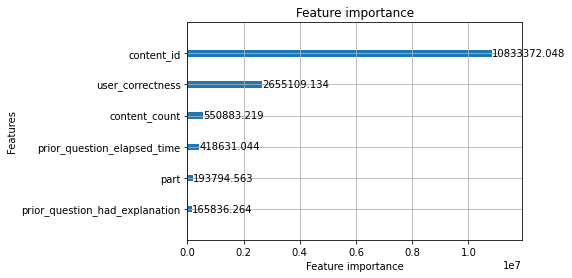

CPU times: user 2h 1min 18s, sys: 1min 19s, total: 2h 2min 38s
Wall time: 1h 11min 2s


In [18]:
%%time

tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

lgb.plot_importance(model, importance_type='gain')
plt.show()

In [19]:
y_pred = model.predict(valid_df[features])
y_true = np.array(valid_df[target])
roc_auc_score(y_true, y_pred)

0.7376210742042383

# Submit

In [20]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [21]:
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [22]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 572 ms, sys: 49.9 ms, total: 622 ms
Wall time: 721 ms
